In [1]:
%matplotlib inline
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib, collections
from scipy.stats import norm
import imp, os, pickle
import warnings
from matplotlib import collections  as mc
from scipy.stats import poisson
warnings.filterwarnings("ignore")
from scipy.stats import norm
sns.set(style="white")
colors = ["#9b59b6", "#3498db", "#95a5a6", "#e74c3c", "#34495e", "#2ecc71"]

## Parameters

In [2]:
f = 0.1 #Mining rate
m = 1000 #Number of voting chains
log_epsilon = 20 #Confirmation guarantee

## Prism Latency Simulation

In [21]:
# Number of adverserial blocks in private at time t
def adverserial(t, beta, fv):
    x = np.arange(0,100,1)
    mu = fv*t*beta/(1-beta)
    return poisson.pmf(x, mu)

#Probability that a vote with depth k will be removed when adversary has Z_t blocks in private
def p_k_t(k, Z_t,beta):
    ans = 0
    k = int(k)
    for i in range(k):
        ans += Z_t[i]*np.power(beta/(1-beta), k - i)
    ans += np.sum(Z_t[k:])
    return ans

def runExp(m, log_epsilon, fv):
    events = int(2000*log_epsilon)
    beta_array = np.array([ 0.4])
    time_array = np.zeros_like(beta_array)
    fv_effective = fv/(1.0+2*fv) #Forking
    exp_random_v = np.random.exponential(1/(m*fv_effective), size=events)
    chain_random_v = np.random.randint(m, size=events)
    for j, beta in enumerate(beta_array):
#         exponent = 0.8*(1-2*beta)/(1-beta)*np.log((1-beta)/beta)
        votes, votes_permanence_E, votes_permanence_V =  np.zeros(m), np.zeros(m),  np.zeros(m)
        time, mean, var  = 0,0,0
        lower_bar = np.zeros_like(exp_random_v)
        for i, tDiff in enumerate(exp_random_v):
            time += tDiff
            # Adding vote on a random chain
            rChain = chain_random_v[i]
            votes[rChain] +=1
            
            #Solidified probability
            Z_t = adverserial(time, beta, fv)
            p_i = 1 - p_k_t(votes[rChain], Z_t, beta)
#             p_i = 1-np.power(np.e, -votes[rChain]*exponent) # Old calculation.

            #Updating the mean an variance
            mean -= votes_permanence_E[rChain]
            var  -= votes_permanence_V[rChain]
            votes_permanence_E[rChain] = p_i
            votes_permanence_V[rChain] = p_i*(1-p_i)
            mean += votes_permanence_E[rChain]
            var  += votes_permanence_V[rChain]
            lower_bar[i] = mean#-np.sqrt(2*var*log_epsilon)
            # The block got confirmed
            if mean-np.sqrt(2*var*log_epsilon) > m/2+1:
                time_array[j] = time
                lower_bar[i:] = mean#-np.sqrt(2*var*log_epsilon)
                break
    return time_array, lower_bar, votes_permanence_E, votes

beta_array = np.array([0.1, 0.15, 0.2, 0.25, .3, .35, 0.4])
prism_ans = np.zeros_like(beta_array)
#T1: Time taken for a unique proposer block to refer the tx_block
# prism_ans += np.power(np.e, 1*f)/f

#T2: Time taken for a proposer block to get confirmed
no_exp = 5
for i in range(no_exp):
    a, b, c, d = runExp(m, log_epsilon, f)
    prism_ans += a
prism_ans /= no_exp

In [34]:
prism_ans, 15.9*0.66

(array([157.25702861, 157.25702861, 157.25702861, 157.25702861,
        157.25702861, 157.25702861, 157.25702861]), 10.494000000000002)

(array([  2.,   4.,   6.,  19.,   0.,  29.,  52.,  72.,  80.,   0., 112.,
         97., 101., 103.,   0.,  93.,  60.,  56.,  35.,   0.,  39.,  21.,
         11.,   5.,   0.,   0.,   1.,   1.,   0.,   1.]),
 array([ 3. ,  3.8,  4.6,  5.4,  6.2,  7. ,  7.8,  8.6,  9.4, 10.2, 11. ,
        11.8, 12.6, 13.4, 14.2, 15. , 15.8, 16.6, 17.4, 18.2, 19. , 19.8,
        20.6, 21.4, 22.2, 23. , 23.8, 24.6, 25.4, 26.2, 27. ]),
 <a list of 30 Patch objects>)

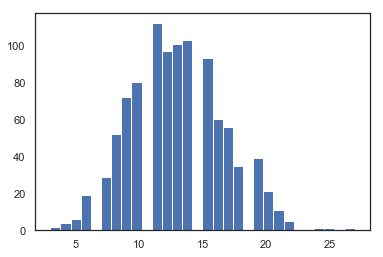

In [33]:
plt.hist(d, bins=30)
# plt.xlabel("Depth")
# plt.show()

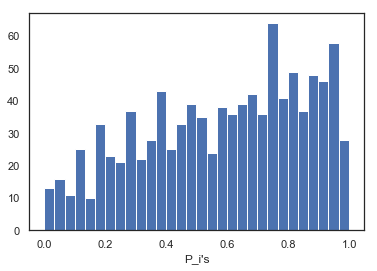

In [29]:
plt.hist(c, bins=30)
plt.xlabel("P_i's")
plt.show()

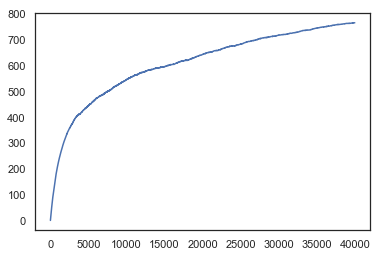

In [18]:
plt.plot(b)

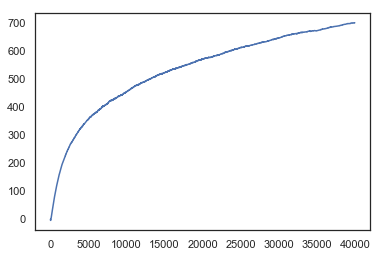

In [16]:
plt.plot(b)

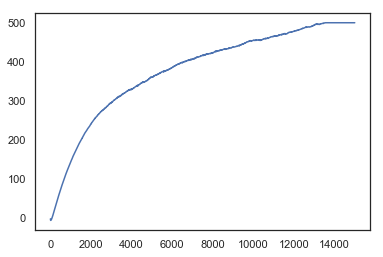

In [11]:
plt.plot(b[:15000])

## Bitcoin Latency calculation

In [4]:
exponent = 0.8*(1-2*beta_array)/(1-beta_array)*np.log((1-beta_array)/beta_array)
bitcoin_ans= (log_epsilon+np.log2(150))/(exponent*f)

## Plot

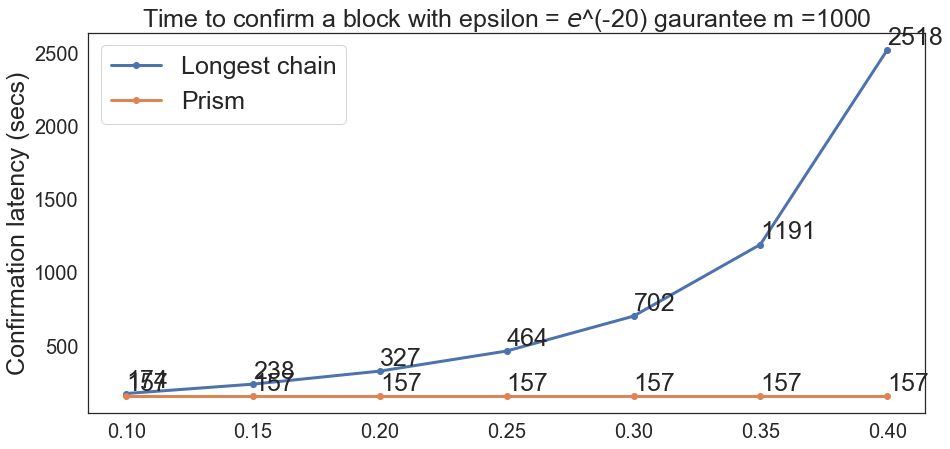

In [35]:
fig = plt.figure(figsize=(15,7))
ax = fig.add_subplot(111)

bitcoin_ans = bitcoin_ans.astype(int)
prism_ans = prism_ans.astype(int)
plt.plot(beta_array, bitcoin_ans, '-o', lw=3, label="Longest chain")
plt.plot(beta_array, prism_ans, '-o',lw=3, label="Prism")
for i in range(bitcoin_ans.shape[0]):
    ax.annotate(bitcoin_ans[i],xy=(beta_array[i],bitcoin_ans[i]+40), size=25)
    ax.annotate(prism_ans[i],xy=(beta_array[i],prism_ans[i]+40), size=25)
plt.ylabel("Confirmation latency (secs)", size=25)
# plt.xlabel("Beta", size=30)
plt.tick_params(axis='both', which='major', labelsize=20)
plt.title("Time to confirm a block with epsilon = $e$^("+str(-log_epsilon)+") gaurantee m ="+str(m), size=25)
plt.legend(prop={'size': 25})
plt.show()
